# DeepWeeds - MobileNet

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import random
import os
import shutil

seed = 999
def seedEverything(seed, deterministic = False):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.keras.utils.set_random_seed(seed)

    if deterministic:
        tf.config.experimental.enable_op_determinism()

        os.environ['TF_DETERMINISTIC_OPS'] = '1'
        os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

        tf.config.threading.set_inter_op_parallelism_threads(2)
        tf.config.threading.set_intra_op_parallelism_threads(2)


seedEverything(seed, True)

2025-05-05 05:43:15.702282: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-05 05:43:15.702407: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-05 05:43:15.825257: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
## Downloading DeepWeeds Data  ## For Google Colab
# url = 'https://drive.google.com/uc?export=download&id=1xnK3B6K6KekDI55vwJ0vnc2IGoDga9cj'
# !gdown 1xnK3B6K6KekDI55vwJ0vnc2IGoDga9cj
# !unzip -qq images.zip -d images

In [3]:
# data_info = pd.read_csv('https://raw.githubusercontent.com/AlexOlsen/DeepWeeds/master/labels/labels.csv') ## for GoogleColab
data_info = pd.read_csv("/kaggle/input/deepweeds/labels.csv") ## For Kaggle
data_info

,Filename,Label,Species
0,20160928-140314-0.jpg,0,Chinee apple
1,20160928-140337-0.jpg,0,Chinee apple
2,20160928-140731-0.jpg,0,Chinee apple
3,20160928-140747-0.jpg,0,Chinee apple
4,20160928-141107-0.jpg,0,Chinee apple
...,...,...,...
17504,20180322-133822-1.jpg,8,Negative
17505,20180322-133832-1.jpg,8,Negative
17506,20180322-133840-1.jpg,8,Negative
17507,20180322-133850-1.jpg,8,Negative


In [4]:
data_info[['Species','Label']].groupby(by='Species').count().T

Species,Chinee apple,Lantana,Negative,Parkinsonia,Parthenium,Prickly acacia,Rubber vine,Siam weed,Snake weed
Label,1125,1064,9106,1031,1022,1062,1009,1074,1016


In [5]:
label2id = data_info[['Species','Label']].groupby(by='Species').min().to_dict()['Label']
id2label = {label2id[i]:i for i in label2id}
id2label

{0: 'Chinee apple',
 1: 'Lantana',
 8: 'Negative',
 2: 'Parkinsonia',
 3: 'Parthenium',
 4: 'Prickly acacia',
 5: 'Rubber vine',
 6: 'Siam weed',
 7: 'Snake weed'}

In [6]:
low_data_labels = data_info[data_info['Species'] != "Negative"]['Label'].unique() ## labels with very low data
low_data_labels

array([0, 1, 7, 6, 4, 3, 5, 2])

# Splitting Data into Train:Valid:Test Splits (60:20:20)

In [7]:
# colabAI prompt: train test split using data_info
from sklearn.model_selection import train_test_split, StratifiedKFold

### K-Fold Validation-----
#####---------------------
split_index = 0 # index to retrieve
print("Using KFold: Index",split_index+1,"out of 5 folds")
print("-------------------------------------------------\n")

# skfold = StratifiedKFold()
# kSplits = skfold.split(data_info['Filename'], y=data_info['Label'])

# for index in range(skfold.get_n_splits()):
#     train_index, test_index = next(kSplits)
#     if index == split_index:
#         break

# trax, tex, tray, tey = train_test_split(data_info['Filename'],data_info['Label'], test_size=0.4, random_state=seed)
# train_data = pd.DataFrame({"Filename":trax,"label":tray})

# trax, tex, tray, tey = train_test_split(tex,tey, test_size=0.5, random_state=seed)
# valid_data = pd.DataFrame({"Filename":trax,"label":tray})
# test_data = pd.DataFrame({"Filename":tex,"label":tey})

Using KFold: Index 1 out of 5 folds
-------------------------------------------------



In [8]:
train_data = pd.read_csv('https://raw.githubusercontent.com/AlexOlsen/DeepWeeds/master/labels/train_subset{}.csv'.format(split_index)) ## for GoogleColab
train_data.rename(columns={"Label":"label"}, inplace=True)

valid_data = pd.read_csv('https://raw.githubusercontent.com/AlexOlsen/DeepWeeds/master/labels/val_subset{}.csv'.format(split_index)) ## for GoogleColab
valid_data.rename(columns={"Label":"label"}, inplace=True)
test_data = pd.read_csv('https://raw.githubusercontent.com/AlexOlsen/DeepWeeds/master/labels/test_subset{}.csv'.format(split_index)) ## for GoogleColab
test_data.rename(columns={"Label":"label"}, inplace=True)

print("Is There Duplicates: ", not valid_data[valid_data['Filename'].isin(test_data['Filename'])].empty)
print("Train Data\n--------\n",train_data.groupby(by='label').count().T, "\tTotal:", train_data.shape)
print("Validation Data\n--------\n",valid_data.groupby(by='label').count().T, "\tTotal:", valid_data.shape)
print("Test Data\n--------\n",test_data.groupby(by='label').count().T, "\tTotal:", test_data.shape)

Is There Duplicates:  False
Train Data
--------
 label       0    1    2    3    4    5    6    7     8
Filename  675  637  618  613  637  605  644  609  5463 	Total: (10501, 2)
Validation Data
--------
 label       0    1    2    3    4    5    6    7     8
Filename  225  213  206  204  212  202  215  203  1821 	Total: (3501, 2)
Test Data
--------
 label       0    1    2    3    4    5    6    7     8
Filename  226  213  207  205  213  202  215  204  1822 	Total: (3507, 2)


# Helper Functions

- Organize Images to Directory as per Label for Creating Generator (organize_data_to_directory)
- Dataset Generator (getDatasetGenerators) - works in tandem with "organize_data_to_directory"
- Class Weights For Imbalanced Dataset (getWeightedClass)
- Accuracy / Loss plot (plot_loss_acc)
- Evaluation Metrics Calculation (eval_model, print_stats, calcFalseRate)
- Prediction with Threshold as used by DeepWeeds Author (prediction_argmax)



In [9]:
from tqdm import tqdm

def organize_data_to_directory(data_info,source_dir='',target_dir='',oversample=0,oversampling_labels=[]):
    for index, row in tqdm(data_info.iterrows()):
        filename = row['Filename']
        label = row['label']

        source = os.path.join(source_dir,filename)

        #if not os.path.exists(source):
        #    print("File Doesn't Exist", source)
        #    continue

        target_path = os.path.join(target_dir,str(label))
        target = os.path.join(target_path,filename)
        # print(source,target)

        if not os.path.exists(target_path):
            os.mkdir(target_path)

        if not os.path.exists(target):
            if oversample and (label in oversampling_labels):
                for i in range(oversample):
                    sample_filename = os.path.join(target_path, "oversample-"+str(i)+"-"+filename)
                    shutil.copy(source, sample_filename)

            shutil.copy(source,target)

##-----------------------------
###----------------------------

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import image_dataset_from_directory

def getDatasetGenerators(train_dir, **kwargs):
    # --------------------
    # Flow training images in batches using generator
    # --------------------
    generator = image_dataset_from_directory(
        train_dir,
        **kwargs
    )

    return generator

In [10]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

def prediction_argmax(prediction, rand_guess=1):
    prediction = np.asarray(prediction)
    l_pred = np.argmax(prediction[low_data_labels])
    if(prediction[l_pred] > rand_guess):
        return l_pred

    return np.argmax(prediction)

def calcFalsePositiveRate(a_label, p_label, label_names=None, n_class=None):
    if n_class is None:
        n_class = len(np.unique(a_label))
    conf_mat = tf.math.confusion_matrix(a_label, p_label, num_classes=n_class).numpy()

    false_rate = []
    total = len(a_label)
    for i in range(n_class):
        tP = conf_mat[i][i]
        fN = np.sum(conf_mat[i,:]) - tP

        fP = np.sum(conf_mat[:,i]) - tP
        tN = total - (tP + fN + fP)

        fP_Rate = fP/(tN+fP)
        # fN_Rate = fN/(tP+fN)
        accuracy = tP / (tP+fN)

        false_rate.append((fP_Rate,accuracy))

    false_rate = pd.DataFrame(false_rate, columns=["False Positive Rate", "Accuracy"], index=label_names)
    return false_rate

def printStats(actual_labels,prediction, use_rand_guess= 0):
    if use_rand_guess:
        prediction = [prediction_argmax(x, rand_guess=use_rand_guess) for x in prediction]
    else:
        prediction = [np.argmax(x) for x in prediction]

    print("Evaluation Metrics\n=================================\n")
    #     print("F1-Score",f1_score(actual_labels,prediction,average='weighted'))
    #     print("Precision-Score",precision_score(actual_labels,prediction,average='weighted'))
    #     print("Recall-Score",recall_score(actual_labels,prediction,average='weighted'))
    #     print("accuracy_Score",accuracy_score(actual_labels,prediction))

    label_names = [id2label[i] for i in range(len(id2label))]
    print(classification_report(actual_labels, prediction,digits=5, target_names=label_names))
    print()
    print(calcFalsePositiveRate(actual_labels, prediction, label_names = label_names))
    print()
    print("Confusion Matrix\n=================================\n")
    n_class = np.unique(actual_labels).shape[0]
    cmd = ConfusionMatrixDisplay.from_predictions(
        actual_labels, prediction,
        display_labels=label_names,
        xticks_rotation=45 #'vertical'
    )
    #cmd.plot()
    plt.show()

def eval_model(model, data_gen, use_rand_guess=False):
    print("model.evaluate")
    model.evaluate(data_gen)

    print("model.predict")
    actual_labels = []
    pred_prob = []
    for batch in tqdm(data_gen):
        actual_labels.extend([np.argmax(z) for z in batch[1]])
        pred_prob.extend(list(model(batch[0], training=False)))

    printStats(actual_labels,pred_prob,use_rand_guess)
    return actual_labels, pred_prob


def plot_loss_acc(history):
    '''Plots the training and validation loss and accuracy from a history object'''
    acc = history['accuracy']
    val_acc = history['val_accuracy']
    loss = history['loss']
    val_loss = history['val_loss']
    if 'peaks' in history:
        peaks = history['peaks']
    else:
        _min = np.argmin(val_loss)
        peaks = [_min]

    epochs = range(len(acc))
    print("Total Epochs:",epochs)

    plt.figure(figsize=[16, 4])
    plt.subplot(1,2,1)
    p_value = [val_acc[p] for p in peaks]
    plt.scatter(peaks, p_value, marker='o',s=50)
    plt.plot(epochs, acc, label='Training accuracy', color='red')
    plt.plot(epochs, val_acc, label='Validation accuracy', color='magenta')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    p_value = [val_loss[p] for p in peaks]
    plt.scatter(peaks, p_value, marker='o',s=50)
    plt.plot(epochs, loss, label='Training Loss', color='red')
    plt.plot(epochs, val_loss, label='Validation Loss', color='magenta')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

# Creating Dateset ImageGenerator

In [11]:
IMG_SIZE=(224,224,3)
oversampling = 0 # How many times are we gonna over sample

if oversampling:
    print("Oversampling",oversampling,"times for labels",low_data_labels)
else:
    print("No OverSampling")

# base_dir = '/content/dataset_9c' ## For GoogleColab
# input_dir = '/content/images' ## For GoogleColab

input_dir = "/kaggle/input/deepweeds/images" ## For Kaggle
base_dir = "/kaggle/working/deepweeds_9c" ## For Kaggle

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

if os.path.exists(base_dir):
    shutil.rmtree(base_dir)

os.mkdir(base_dir)
os.mkdir(train_dir)
os.mkdir(validation_dir)
os.mkdir(test_dir)

## Organizing Training Data
organize_data_to_directory(train_data, source_dir=input_dir, target_dir=train_dir, oversample=oversampling, oversampling_labels=low_data_labels)

# ## Organizing Validation Data
organize_data_to_directory(valid_data, source_dir=input_dir, target_dir=validation_dir)

# ## Organizing Test Data
organize_data_to_directory(test_data, source_dir=input_dir, target_dir=test_dir)

No OverSampling


10501it [01:51, 93.90it/s] 
3501it [00:36, 95.86it/s] 
3507it [00:34, 100.64it/s]


In [12]:
train_generator = getDatasetGenerators(
      train_dir,
      batch_size=32,
      label_mode='categorical',
      image_size = IMG_SIZE[:2],
      shuffle=True
)

validation_generator = getDatasetGenerators(
      validation_dir,
      batch_size=16,
      label_mode='categorical',
      image_size = IMG_SIZE[:2],
      shuffle=True
)

test_generator = getDatasetGenerators(
      test_dir,
      batch_size=16,
      label_mode='categorical',
      image_size = IMG_SIZE[:2],
      shuffle=False
)

Found 10501 files belonging to 9 classes.
Found 3501 files belonging to 9 classes.
Found 3507 files belonging to 9 classes.


# Sample Images

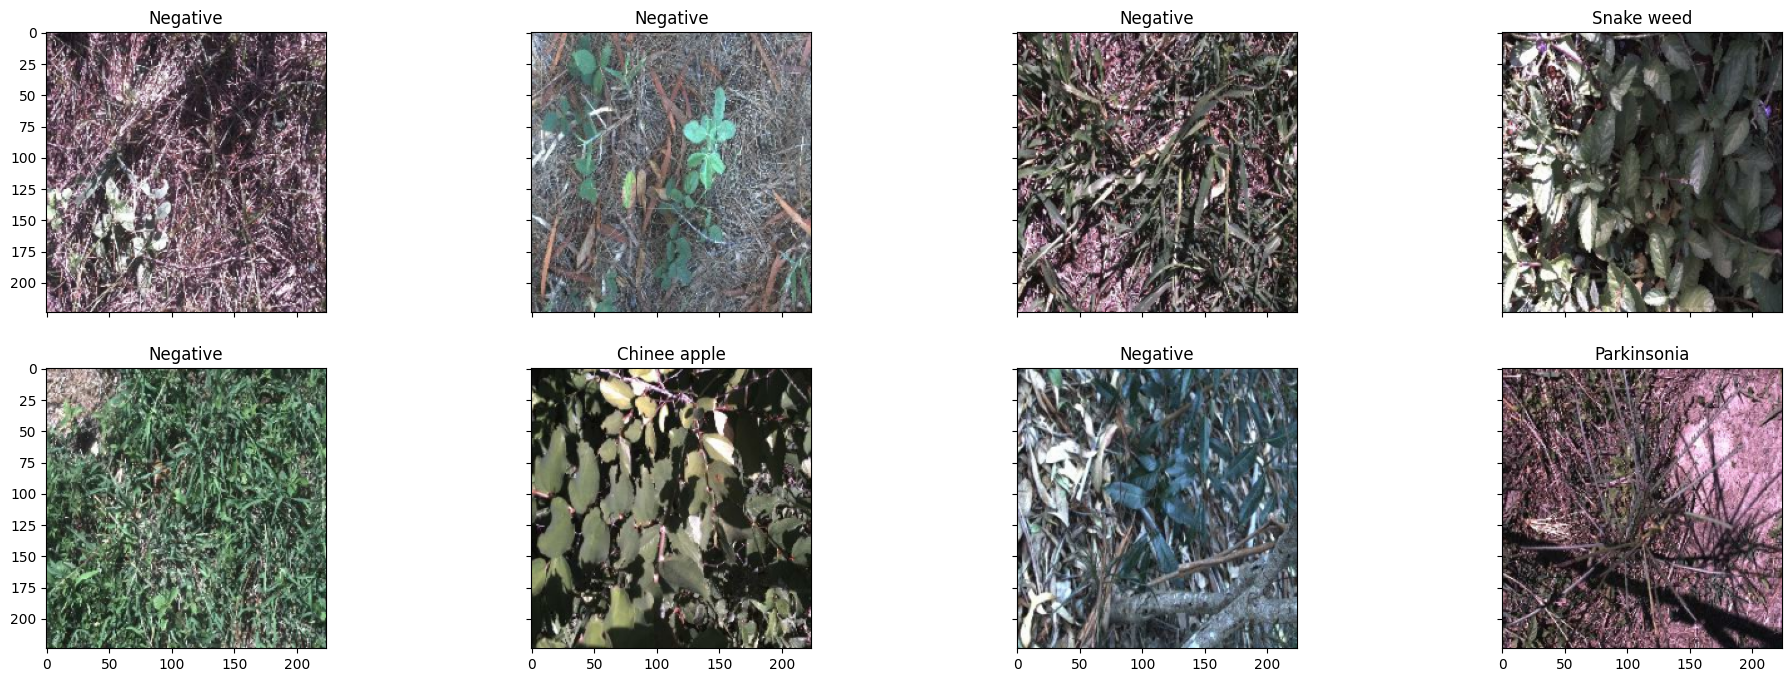

In [13]:
#image visualization
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(24,8))

for images, labels in validation_generator:
    for i in range(2):
        for j in range(4):
            ax[i][j].imshow(images[i+j*2].numpy().astype(np.int32))
            ax[i][j].set_title(id2label[np.argmax(labels[i+j*2])])

    break
plt.show()

In [14]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, MaxPool2D, Reshape, \
                        Dense, multiply, Permute, Concatenate, Conv2D, Add, Activation, Lambda, Average
from tensorflow.keras import backend as K
from tensorflow.keras.activations import sigmoid, softmax

class ChannelWiseMaxPool(tf.keras.layers.Layer):
    def __init__(self,pool_size=2,stride=None,padding='valid',data_format='channels_last', **kwargs):
        super(ChannelWiseMaxPool,self).__init__(**kwargs)
        self.pool_size = pool_size
        self.stride = stride
        self.padding = padding
        if stride is None:
            self.stride = self.pool_size

        self.data_format = 'channels_last' if data_format == 'channels_first' else 'channels_first'
        self.max = tf.keras.layers.MaxPool1D(self.pool_size, self.stride, padding=self.padding, data_format=self.data_format)

    def build(self,input_shape):
        self.reshape_forward = tf.keras.layers.Reshape((-1,input_shape[-1]))
        self.reshape_backward= tf.keras.layers.Reshape((input_shape[1], input_shape[2], -1))

    def call(self,x):
        x = self.reshape_forward(x)
        x = self.max(x)
        x = self.reshape_backward(x)
        return x

class ChannelWiseAvgPool(tf.keras.layers.Layer):
    def __init__(self,pool_size=2,stride=None,padding='valid',data_format='channels_last', **kwargs):
        super(ChannelWiseAvgPool,self).__init__(**kwargs)
        self.pool_size = pool_size
        self.stride = stride
        self.padding = padding
        if stride is None:
            self.stride = self.pool_size

        self.data_format = 'channels_last' if data_format == 'channels_first' else 'channels_first'
        self.avg = tf.keras.layers.AveragePooling1D(self.pool_size, self.stride, padding=self.padding, data_format=self.data_format)

    def build(self,input_shape):
        self.reshape_forward = tf.keras.layers.Reshape((-1,input_shape[-1]))
        self.reshape_backward= tf.keras.layers.Reshape((input_shape[1], input_shape[2], -1))

    def call(self,x):
        x = self.reshape_forward(x)
        x = self.avg(x)
        x = self.reshape_backward(x)
        return x

def GlobalAverageOfMaximums(x, max_pool_size=2, layer_num=1, keep_out_dims=False):
    _max = layers.MaxPooling2D(pool_size=max_pool_size,padding='same', name="Maximums_L{}".format(layer_num))(x)
    _avg = layers.GlobalAveragePooling2D(name="Average_of_Maximums_L{}".format(layer_num), keepdims=keep_out_dims)(_max)
    return _avg

In [15]:
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, MaxPool2D, Reshape, \
Dense, multiply, Permute, Concatenate, Conv2D, Add, Activation, Lambda, Average
from tensorflow.keras import backend as K
from tensorflow.keras.activations import sigmoid, softmax

def cbam_block(cbam_feature, ratio=8):
    """Contains the implementation of Convolutional Block Attention Module(CBAM) block.
    As described in https://arxiv.org/abs/1807.06521.
    """

    cbam_feature = channel_attention(cbam_feature, ratio)
    cbam_feature = spatial_attention(cbam_feature)
    return cbam_feature

def channel_attention(input_feature, ratio=8, seed=42):
    channel_axis = 1 if K.image_data_format() == "channels_first" else -1
    channel = input_feature.shape[channel_axis]

    shared_layer_one = Dense(channel//ratio,
                             activation='relu',
                             kernel_initializer=keras.initializers.HeUniform(seed),
                             use_bias=True,
                             bias_initializer=keras.initializers.GlorotUniform(seed),
                           name='Dense_Squeeze_CA')
    shared_layer_two = Dense(channel,
                             kernel_initializer=keras.initializers.HeUniform(seed),
                             use_bias=True,
                             bias_initializer=keras.initializers.GlorotUniform(seed),
                           name='Dense_Excite_CA')

    avg_pool = GlobalAveragePooling2D()(input_feature)
    avg_pool = Reshape((1,1,channel))(avg_pool)
    assert avg_pool.shape[1:] == (1,1,channel)

    avg_pool = shared_layer_one(avg_pool)
    assert avg_pool.shape[1:] == (1,1,channel//ratio)

    avg_pool = shared_layer_two(avg_pool)
    assert avg_pool.shape[1:] == (1,1,channel)

    max_pool = GlobalMaxPooling2D()(input_feature)
    max_pool = Reshape((1,1,channel))(max_pool)
    assert max_pool.shape[1:] == (1,1,channel)

    max_pool = shared_layer_one(max_pool)
    assert max_pool.shape[1:] == (1,1,channel//ratio)

    max_pool = shared_layer_two(max_pool)
    assert max_pool.shape[1:] == (1,1,channel)

    cbam_feature = Add()([avg_pool,max_pool])
    cbam_feature = Activation('sigmoid')(cbam_feature)

    if K.image_data_format() == "channels_first":
        cbam_feature = Permute((3, 1, 2))(cbam_feature)

    return multiply([input_feature, cbam_feature])



def spatial_attention(input_feature, seed=42):
    kernel_size = 5

    if K.image_data_format() == "channels_first":
        channel = input_feature.shape[1]
        cbam_feature = Permute((2,3,1))(input_feature)
    else:
        channel = input_feature.shape[-1]
        cbam_feature = input_feature

    avg_pool = Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(cbam_feature)
    assert avg_pool.shape[-1] == 1

    max_pool = Lambda(lambda x: K.max(x, axis=3, keepdims=True))(cbam_feature)
    assert max_pool.shape[-1] == 1

    concat = Concatenate(axis=3)([avg_pool, max_pool])
    assert concat.shape[-1] == 2

    cbam_feature = Conv2D(filters = 1,
                    kernel_size=kernel_size,
                    strides=1,
                    padding='same',
                    activation='sigmoid',
                    kernel_initializer=keras.initializers.HeUniform(seed),
                    use_bias=False)(concat)
    assert cbam_feature.shape[-1] == 1

    if K.image_data_format() == "channels_first":
        cbam_feature = Permute((3, 1, 2))(cbam_feature)

    return multiply([input_feature, cbam_feature])

In [16]:
import math
### MFSA
def MultiFilterSpatialAttention(input_feature, kernel_size=7, num_pooled_channel=4, seed=42, layer_num = 0):
    in_shape = input_feature.shape

    stride = int(math.ceil(in_shape[-1] / num_pooled_channel))
    pool_size = (stride * 2)

    channel_avg = ChannelWiseAvgPool(pool_size, stride, padding='same', name='MFSA_SAP_L{}'.format(layer_num))(input_feature)
    channel_max = ChannelWiseMaxPool(pool_size, stride, padding='same' , name='MFSA_SMP_L{}'.format(layer_num))(input_feature)

    concat = layers.Concatenate(axis=3, name='MFSA_ConcatChannels_L{}'.format(layer_num))([channel_avg, channel_max])

    mfsa_out = layers.Conv2D(filters = in_shape[-1],
                    kernel_size=kernel_size,
                    strides=1,
                    padding='same',
                    activation='sigmoid',
                    kernel_initializer=keras.initializers.HeUniform(seed),
                    use_bias=False,
                    groups=num_pooled_channel,
                    name="MFSA_Conv_L{}".format(layer_num))(concat)	
    
    mfsa_out =  layers.Multiply(name="MFSA_Multiply_L{}".format(layer_num))([input_feature, mfsa_out])
    
    return mfsa_out

# Building MobileNet Model

In [ ]:
from tensorflow.keras.applications import MobileNet, MobileNetV2, MobileNetV3Small, MobileNetV3Large
from tensorflow.keras.applications import EfficientNetV2S, ConvNeXtSmall

def augment(seed=42):
    return keras.Sequential([
        layers.RandomBrightness(0.3, (0, 1),seed=seed, name='RR_Bright'),
        # layers.RandomContrast(0.3, seed=seed, name='RR_Contr'), # can't run deterministically
        layers.RandomFlip(seed=seed, name='RR_Flip'),
        layers.RandomRotation(0.5, seed=seed, name='RR_Rot'),
        layers.RandomTranslation(0.4, 0.4, seed=seed, name='RR_Trans'),
        layers.RandomZoom(0.2, 0.2, seed=seed, name='RR_Zoom'),
        layers.GaussianDropout(0.01, seed=seed, name='RR_Gauss'),
    ], name='augment_pipeline')


def skipAugment(model):
    inputs = keras.Input(shape=IMG_SIZE)
    x = inputs
    for layer in model.layers:
        if 'augment' not in layer.name and 'input' not in layer.name:
            x = layer(x)

    model = keras.Model(inputs=inputs, outputs=x, name=model.name)
    return model

def hard_swish(x):
    relu6 = layers.ReLU(max_value=6)
    return x * (relu6(x + 3) / 6)

def MobilenetV3Base(img_size, use='S'): # use = S (small) or L (large)
    # Load the MobileNet model with weights pre-trained on ImageNet.
    if(use=='S'):
        mobilenet = MobileNetV3Small(input_shape=img_size, weights='imagenet', include_preprocessing=False)
    if(use=='L'):
        mobilenet = MobileNetV3Large(input_shape=img_size, weights='imagenet', include_preprocessing=False)
        
    mobilenet.trainable = True

    base_index = 0
    for i in range(len(mobilenet.layers)):
        if('global_average_pooling2d' in mobilenet.layers[i].name):
            base_index = i
            break
            
    out_layer = mobilenet.layers[base_index-1]
    base_model =  keras.Model(inputs=mobilenet.layers[0].output, outputs=out_layer.output, name = mobilenet.name+"_base_")
    base_model.trainable = True
    
    pi0 = base_index+1 # pooler index start
    pi1 = base_index+1 # pooler index end
    for i in range(base_index, len(mobilenet.layers)):
        if('dropout' in mobilenet.layers[i].name):
            pi1 = i
            break
    
    pooler = keras.Model(inputs=mobilenet.layers[pi0].input, outputs=mobilenet.layers[pi1].output, name="MobileNet-Pooler")
    
    return base_model , pooler

def buildModel(IMG_SIZE, mtype = 'S'):
    # Load the MobileNet model with weights pre-trained on ImageNet.
    base_model, pooler = MobilenetV3Base(IMG_SIZE, use=mtype)
    base_model.trainable = True
    pooler.trainable = True
    # out_dim = 1024 if "small" in base_model.name.lower() else 1280 if "large" in base_model.name.lower() else base_model.output.shape[-1]

    print("Base Model:", base_model.name)
    print(len(base_model.layers))
    
    # Define the input layer.
    inputs = keras.Input(shape=IMG_SIZE, name='input')

    # Pre-process the input.
    x = layers.Rescaling(1./255, name='PP_Rescale_down')(inputs)
    x = layers.Resizing(IMG_SIZE[0], IMG_SIZE[1], name='PP_Resize')(x)

    x = augment(seed)(x)
    x = base_model(x, training=True)
    x = layers.Dropout(0.2, seed=seed)(x) 
    gavm_x = GlobalAverageOfMaximums(x, keep_out_dims=True)
    
    ### CBAM
    x = channel_attention(x, seed=seed)
    x = MultiFilterSpatialAttention(x, 5, 16, seed=seed)
    x = layers.Dropout(0.2, seed=seed)(x) 
    ##===================
    ### Global Average of Maximums
    gavm_cbam = GlobalAverageOfMaximums(x, layer_num="Pre-Attention", keep_out_dims=True)

    x = layers.Average()([gavm_x, gavm_cbam])
    x = pooler(x, training=True)    
    flatten = layers.Flatten()
    x = flatten(x)
    
    outputs = layers.Dense(9, kernel_initializer=keras.initializers.HeUniform(seed), activation='softmax')(x)

    model_name = "DeepWeeds-" + base_model.name
    # Create the model.
    model = keras.Model(inputs=inputs, outputs=outputs, name=model_name)

    return model

In [18]:
model = buildModel(IMG_SIZE)
model.summary()

10734624/10734624 [==============================] - 0s 0us/step
Base Model: MobilenetV3small_base_
228
Model: "DeepWeeds-MobilenetV3small_base_"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 PP_Rescale_down (Rescaling  (None, 224, 224, 3)          0         ['input[0][0]']               
 )                                                                                                
                                                                                                  
 PP_Resize (Resizing)        (None, 224, 224, 3)          0         ['PP_Rescale_down[0][0]']     
                                                              

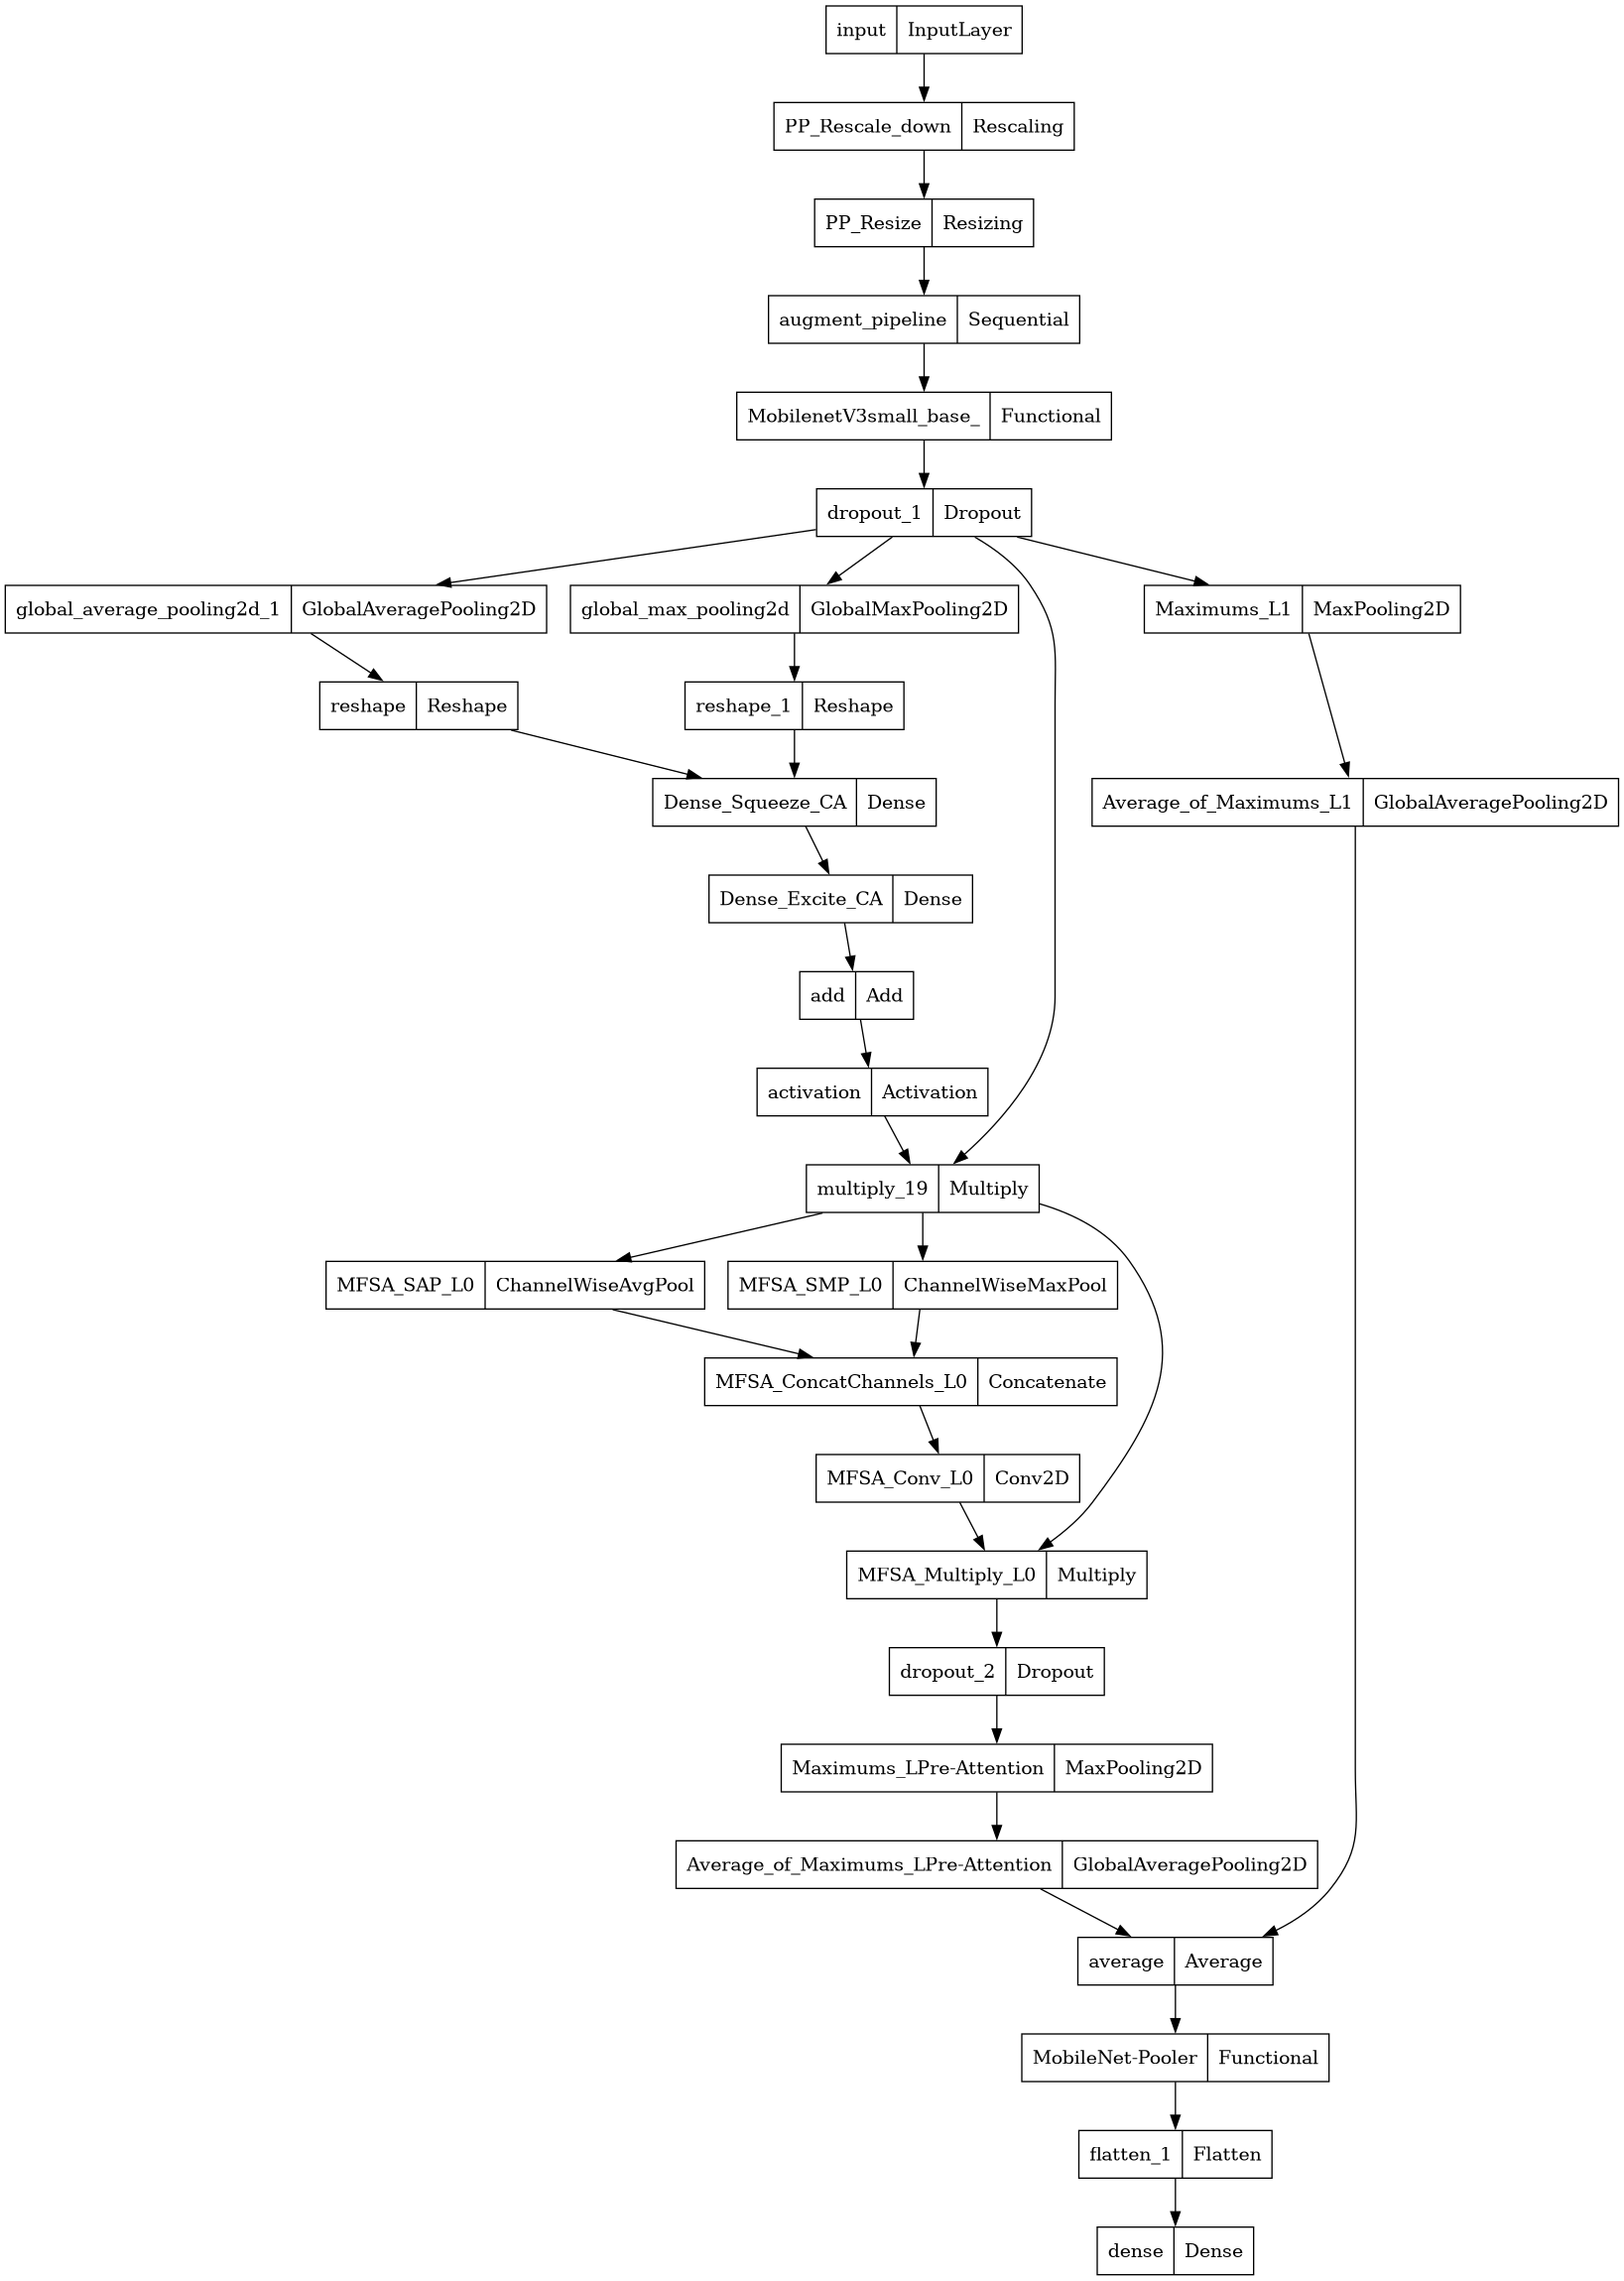

In [19]:
tf.keras.utils.plot_model(model)

# Trial 1 - FineTuning

In [20]:
from tensorflow.keras.optimizers import RMSprop, AdamW

# Constant for epochs
EPOCHS = 200

pat_es = 10
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=pat_es, verbose=1, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.8, patience=3, verbose=1, min_lr=1e-6)

model.compile(loss='categorical_crossentropy',
          optimizer=AdamW(learning_rate=2e-4,  weight_decay=5e-2),
          metrics=['accuracy'])

Epoch 1/200


2025-05-05 05:46:53.540229: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inDeepWeeds-MobilenetV3small_base_/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1746424018.543517      71 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


329/329 [==============================] - 54s 79ms/step - loss: 1.2425 - accuracy: 0.5770 - val_loss: 0.8928 - val_accuracy: 0.6898 - lr: 2.0000e-04
Epoch 2/200
329/329 [==============================] - 24s 74ms/step - loss: 0.8602 - accuracy: 0.6968 - val_loss: 0.7064 - val_accuracy: 0.7446 - lr: 2.0000e-04
Epoch 3/200
329/329 [==============================] - 25s 74ms/step - loss: 0.7027 - accuracy: 0.7524 - val_loss: 0.5843 - val_accuracy: 0.7978 - lr: 2.0000e-04
Epoch 4/200
329/329 [==============================] - 24s 73ms/step - loss: 0.6205 - accuracy: 0.7824 - val_loss: 0.5343 - val_accuracy: 0.8103 - lr: 2.0000e-04
Epoch 5/200
329/329 [==============================] - 25s 74ms/step - loss: 0.5757 - accuracy: 0.7999 - val_loss: 0.4892 - val_accuracy: 0.8343 - lr: 2.0000e-04
Epoch 6/200
329/329 [==============================] - 25s 75ms/step - loss: 0.5181 - accuracy: 0.8180 - val_loss: 0.4610 - val_accuracy: 0.8435 - lr: 2.0000e-04
Epoch 7/200
329/329 [===================

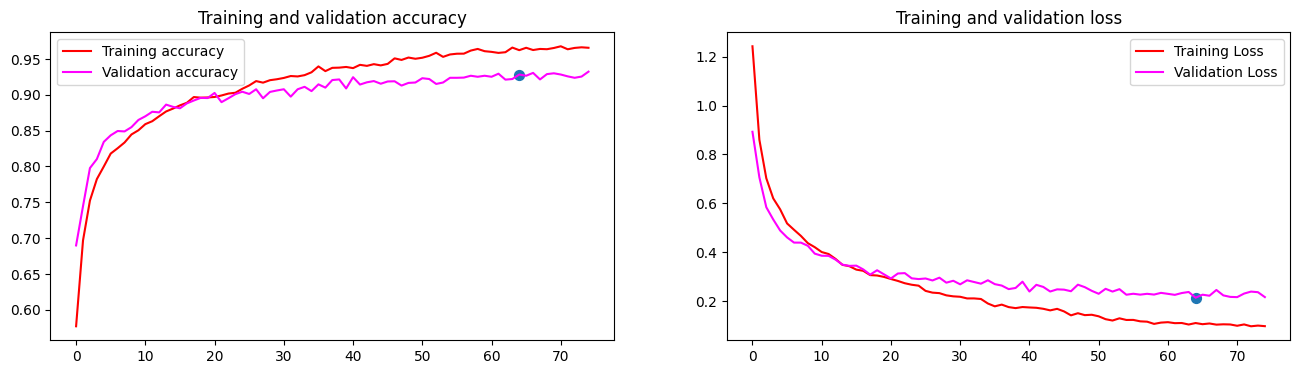

CPU times: user 55min 23s, sys: 2min 50s, total: 58min 13s
Wall time: 31min 32s


In [21]:
%%time

# Train the model
history1 = model.fit(
      train_generator,
      epochs=EPOCHS,
      validation_data=validation_generator,
      callbacks=[early_stopping, reduce_lr],
    )

print("Saving the Model")
model.save(model.name+".keras")

# Plot training results
plot_loss_acc(history1.history)

# Evaluation#1

model.evaluate
219/219 [==============================] - 3s 14ms/step - loss: 0.2303 - accuracy: 0.9237
model.predict


100%|██████████| 219/219 [00:34<00:00,  6.35it/s]


Evaluation Metrics

                precision    recall  f1-score   support

  Chinee apple    0.85714   0.82667   0.84163       225
       Lantana    0.90521   0.89671   0.90094       213
   Parkinsonia    0.93689   0.93689   0.93689       206
    Parthenium    0.91753   0.87255   0.89447       204
Prickly acacia    0.94581   0.90566   0.92530       212
   Rubber vine    0.92574   0.92574   0.92574       202
     Siam weed    0.94330   0.85116   0.89487       215
    Snake weed    0.83756   0.81281   0.82500       203
      Negative    0.93767   0.96650   0.95187      1821

      accuracy                        0.92402      3501
     macro avg    0.91187   0.88830   0.89963      3501
  weighted avg    0.92364   0.92402   0.92349      3501


                False Positive Rate  Accuracy
Chinee apple               0.009463  0.826667
Lantana                    0.006083  0.896714
Parkinsonia                0.003945  0.936893
Parthenium                 0.004853  0.872549
Prickly acacia    

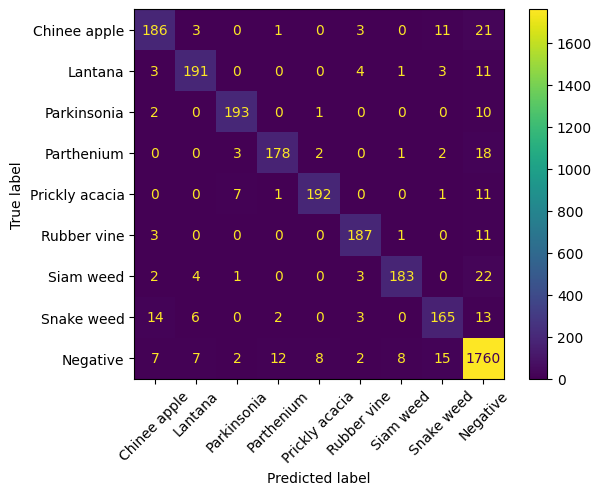

In [22]:
a, b = eval_model(model, validation_generator)

model.evaluate
220/220 [==============================] - 3s 15ms/step - loss: 2.8586 - accuracy: 0.4531
model.predict


100%|██████████| 220/220 [00:34<00:00,  6.37it/s]


Evaluation Metrics

                precision    recall  f1-score   support

  Chinee apple    0.13665   0.09735   0.11370       226
       Lantana    0.09770   0.07981   0.08786       213
   Parkinsonia    0.37037   0.04831   0.08547       207
    Parthenium    0.18841   0.06341   0.09489       205
Prickly acacia    0.18519   0.04695   0.07491       213
   Rubber vine    0.16547   0.11386   0.13490       202
     Siam weed    0.13636   0.04186   0.06406       215
    Snake weed    0.16418   0.10784   0.13018       204
      Negative    0.55199   0.81284   0.65749      1822

      accuracy                        0.45823      3507
     macro avg    0.22181   0.15692   0.16038      3507
  weighted avg    0.37308   0.45823   0.38866      3507


                False Positive Rate  Accuracy
Chinee apple               0.042365  0.097345
Lantana                    0.047662  0.079812
Parkinsonia                0.005152  0.048309
Parthenium                 0.016959  0.063415
Prickly acacia    

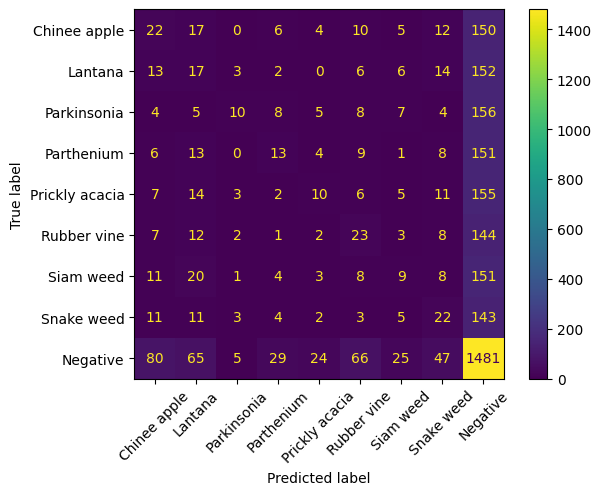

In [23]:
a, b = eval_model(model, test_generator)

# Trial 2 - Freezing Base Model

In [24]:
for layer in model.layers:
    if('mobilenet' in layer.name.lower() or 'pooler' in layer.name.lower()):
        print("Freezing Layer", layer.name)
        layer.trainable = False

model.compile(loss='categorical_crossentropy',
          optimizer=AdamW(learning_rate=2e-5,  weight_decay=5e-5),
          metrics=['accuracy'])

Freezing Layer MobilenetV3small_base_
Freezing Layer MobileNet-Pooler


model.evaluate


2025-05-05 06:19:49.163652: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inDeepWeeds-MobilenetV3small_base_/MobileNet-Pooler/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


220/220 [==============================] - 5s 13ms/step - loss: 0.1506 - accuracy: 0.9549
model.predict


100%|██████████| 220/220 [00:31<00:00,  6.98it/s]


Evaluation Metrics

                precision    recall  f1-score   support

  Chinee apple    0.95545   0.85398   0.90187       226
       Lantana    0.97073   0.93427   0.95215       213
   Parkinsonia    0.95370   0.99517   0.97400       207
    Parthenium    0.91509   0.94634   0.93046       205
Prickly acacia    0.92558   0.93427   0.92991       213
   Rubber vine    0.94416   0.92079   0.93233       202
     Siam weed    0.97115   0.93953   0.95508       215
    Snake weed    0.87907   0.92647   0.90215       204
      Negative    0.96734   0.97530   0.97130      1822

      accuracy                        0.95381      3507
     macro avg    0.94248   0.93624   0.93880      3507
  weighted avg    0.95415   0.95381   0.95366      3507


                False Positive Rate  Accuracy
Chinee apple               0.002743  0.853982
Lantana                    0.001821  0.934272
Parkinsonia                0.003030  0.995169
Parthenium                 0.005451  0.946341
Prickly acacia    

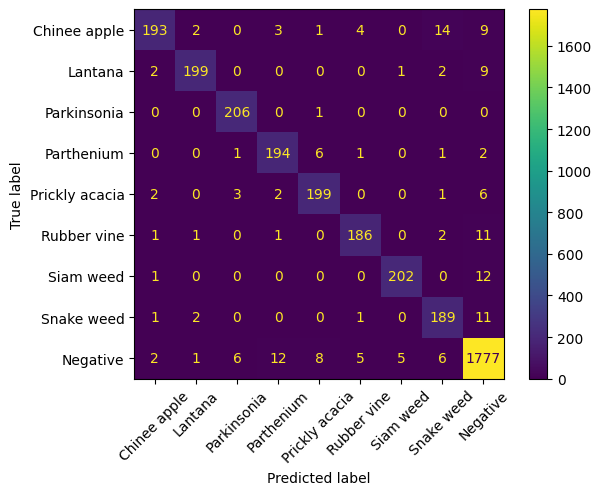

In [25]:
## Test After Freezing
a, b = eval_model(model, test_generator)

Epoch 1/200
329/329 [==============================] - 18s 39ms/step - loss: 0.2217 - accuracy: 0.9199 - val_loss: 0.1663 - val_accuracy: 0.9514 - lr: 2.0000e-05
Epoch 2/200
329/329 [==============================] - 13s 40ms/step - loss: 0.1994 - accuracy: 0.9299 - val_loss: 0.1712 - val_accuracy: 0.9486 - lr: 2.0000e-05
Epoch 3/200
327/329 [============================>.] - ETA: 0s - loss: 0.1939 - accuracy: 0.9330
Epoch 3: ReduceLROnPlateau reducing learning rate to 1.5999999595806004e-05.
329/329 [==============================] - 13s 40ms/step - loss: 0.1946 - accuracy: 0.9328 - val_loss: 0.1699 - val_accuracy: 0.9503 - lr: 2.0000e-05
Epoch 4/200
329/329 [==============================] - 13s 39ms/step - loss: 0.1857 - accuracy: 0.9348 - val_loss: 0.1689 - val_accuracy: 0.9523 - lr: 1.6000e-05
Epoch 5/200
327/329 [============================>.] - ETA: 0s - loss: 0.1909 - accuracy: 0.9319
Epoch 5: ReduceLROnPlateau reducing learning rate to 1.2799999967683107e-05.
329/329 [=======

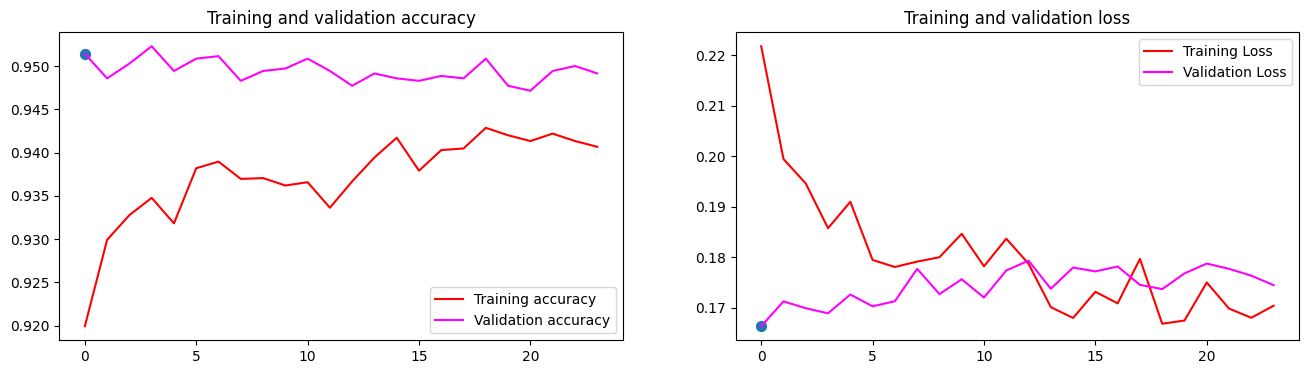

In [26]:
pat_es = 20
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=pat_es, verbose=1, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.8, patience=2, verbose=1, min_lr=1e-9)

# Train the model
history2 = model.fit(
      train_generator,
      epochs=EPOCHS,
      validation_data=validation_generator,
      callbacks=[early_stopping,reduce_lr]
    )

print("Saving the Model")
model.save(model.name+".keras")

# Plot training results
plot_loss_acc(history2.history)

# Accuracy / Loss Plots

Total Epochs: range(0, 99)


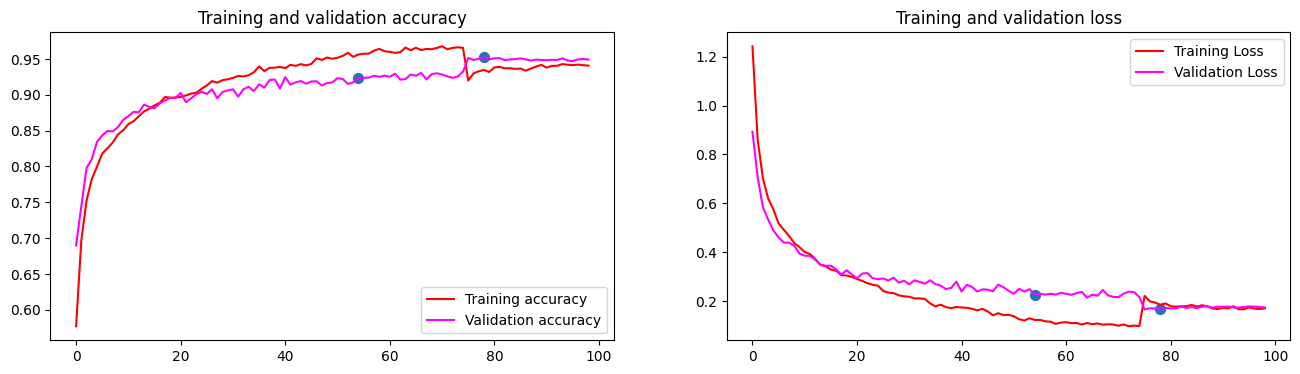

In [27]:
import copy

history = copy.deepcopy(history1.history)

for key in history:
    history[key].extend(history2.history[key])


h1len = len(history1.history['accuracy'])
h2len = len(history2.history['accuracy'])

pat_es +=1
history['peaks'] = [h1len-pat_es, (h1len+h2len)-pat_es]
history['peaks'] = [i if i>=0 else 0 for i in history['peaks']]

plot_loss_acc(history)

Total Epochs: range(0, 75)


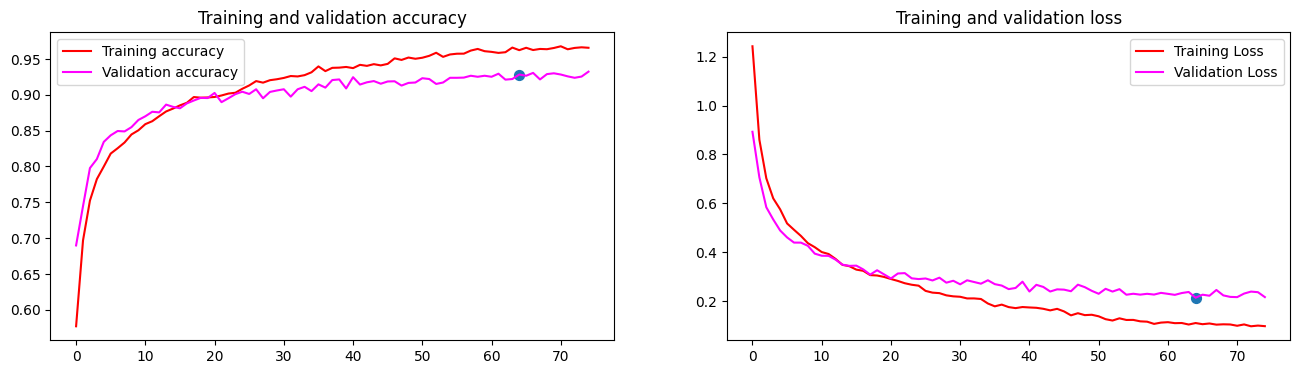

Total Epochs: range(0, 24)


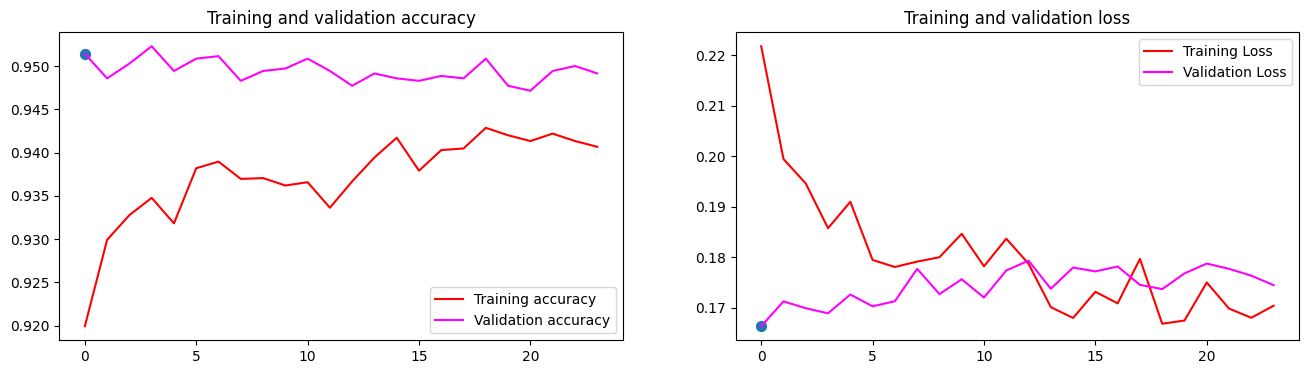

In [28]:
plot_loss_acc(history1.history)
plot_loss_acc(history2.history)

# Evaluation#2

model.evaluate
219/219 [==============================] - 3s 14ms/step - loss: 0.1711 - accuracy: 0.9506
model.predict


100%|██████████| 219/219 [00:32<00:00,  6.73it/s]


Evaluation Metrics

                precision    recall  f1-score   support

  Chinee apple    0.90476   0.84444   0.87356       225
       Lantana    0.97500   0.91549   0.94431       213
   Parkinsonia    0.94313   0.96602   0.95444       206
    Parthenium    0.96482   0.94118   0.95285       204
Prickly acacia    0.93396   0.93396   0.93396       212
   Rubber vine    0.96098   0.97525   0.96806       202
     Siam weed    0.91892   0.94884   0.93364       215
    Snake weed    0.85990   0.87685   0.86829       203
      Negative    0.96730   0.97474   0.97101      1821

      accuracy                        0.95059      3501
     macro avg    0.93653   0.93075   0.93335      3501
  weighted avg    0.95060   0.95059   0.95042      3501


                False Positive Rate  Accuracy
Chinee apple               0.006105  0.844444
Lantana                    0.001521  0.915493
Parkinsonia                0.003642  0.966019
Parthenium                 0.002123  0.941176
Prickly acacia    

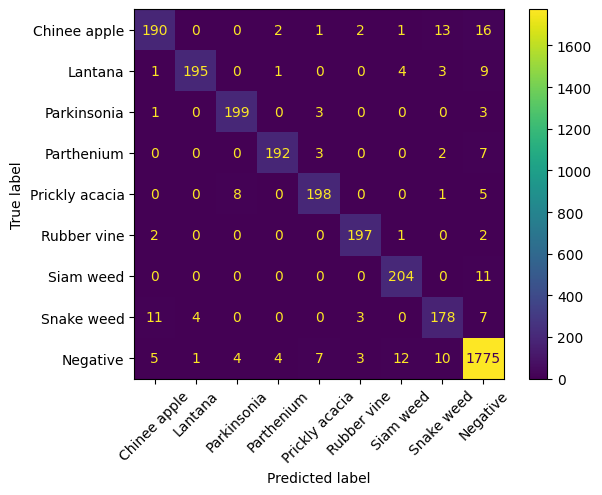

In [29]:
## Computing Positive Threshold Using Validation Dataset
a, b = eval_model(model,validation_generator)

model.evaluate
220/220 [==============================] - 3s 15ms/step - loss: 0.1502 - accuracy: 0.9510
model.predict


100%|██████████| 220/220 [00:33<00:00,  6.56it/s]


Evaluation Metrics

                precision    recall  f1-score   support

  Chinee apple    0.95960   0.84071   0.89623       226
       Lantana    0.96602   0.93427   0.94988       213
   Parkinsonia    0.95794   0.99034   0.97387       207
    Parthenium    0.94203   0.95122   0.94660       205
Prickly acacia    0.91628   0.92488   0.92056       213
   Rubber vine    0.93596   0.94059   0.93827       202
     Siam weed    0.91228   0.96744   0.93905       215
    Snake weed    0.86758   0.93137   0.89835       204
      Negative    0.97193   0.96926   0.97060      1822

      accuracy                        0.95238      3507
     macro avg    0.93662   0.93890   0.93705      3507
  weighted avg    0.95303   0.95238   0.95230      3507


                False Positive Rate  Accuracy
Chinee apple               0.002438  0.840708
Lantana                    0.002125  0.934272
Parkinsonia                0.002727  0.990338
Parthenium                 0.003634  0.951220
Prickly acacia    

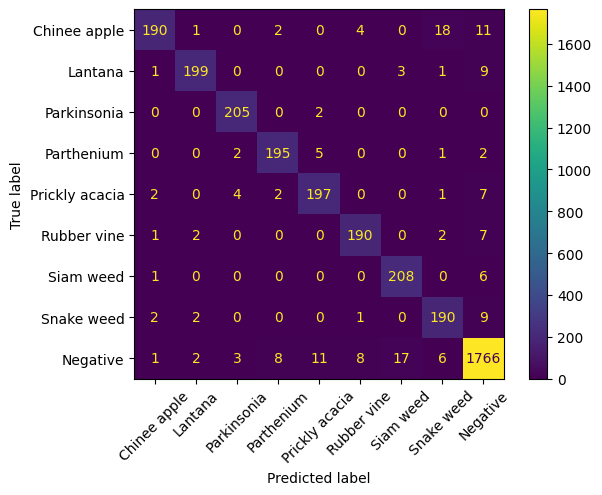

In [30]:
a, b = eval_model(model, test_generator)

Evaluation Metrics

                precision    recall  f1-score   support

  Chinee apple    0.89091   0.86726   0.87892       226
       Lantana    0.90179   0.94836   0.92449       213
   Parkinsonia    0.95775   0.98551   0.97143       207
    Parthenium    0.93720   0.94634   0.94175       205
Prickly acacia    0.87336   0.93897   0.90498       213
   Rubber vine    0.93137   0.94059   0.93596       202
     Siam weed    0.90830   0.96744   0.93694       215
    Snake weed    0.86364   0.93137   0.89623       204
      Negative    0.98069   0.94786   0.96400      1822

      accuracy                        0.94411      3507
     macro avg    0.91611   0.94152   0.92830      3507
  weighted avg    0.94561   0.94411   0.94445      3507


                False Positive Rate  Accuracy
Chinee apple               0.007315  0.867257
Lantana                    0.006679  0.948357
Parkinsonia                0.002727  0.985507
Parthenium                 0.003937  0.946341
Prickly acacia    

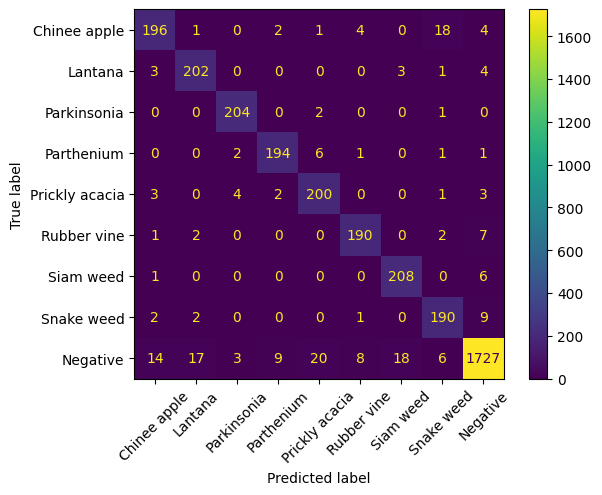

In [31]:
printStats(a,b,0.11)

## Clear Files

In [32]:
shutil.rmtree(base_dir)